### 1. Import Dependencies

In [82]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling3D, Input
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

### 2. Import the Dataset

In [83]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')

In [84]:
print(train_df.columns)

Index(['WIN_20180925_17_08_43_Pro_Left_Swipe_new', 'Left_Swipe_new', '0'], dtype='object')


### 3. Loading Video Frames

In [85]:
FRAME_HEIGHT, FRAME_WIDTH = 64, 64
NUM_CLASSES = 5

def load_data(df, data_dir):
    frames, labels = [], []
    for _, row in df.iterrows():
        video_frames = []
        video_dir = os.path.join(data_dir, row[0])
        for img_name in sorted(os.listdir(video_dir)):
            img = cv2.imread(os.path.join(video_dir, img_name))
            img = cv2.resize(img, (FRAME_WIDTH, FRAME_HEIGHT))
            video_frames.append(img)
        frames.append(video_frames)
        labels.append(row[2])
    return np.array(frames), to_categorical(np.array(labels), NUM_CLASSES)

train_df = pd.read_csv('train.csv', header=None)
val_df = pd.read_csv('val.csv', header=None)

In [86]:
X_train, y_train = load_data(train_df, 'train')

In [87]:
X_val, y_val = load_data(val_df, 'val')

### 4. Model Building - 3D CNN

In [88]:
initial_learning_rate = 0.001

In [89]:
model = Sequential()

# First Conv3D layer
model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=(30, FRAME_HEIGHT, FRAME_WIDTH, 3)))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.05))

# Second Conv3D layer
model.add(Conv3D(64, (3, 3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.05))

# Third Conv3D layer
model.add(Conv3D(128, (3, 3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.05))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\noora\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 5. Callback Setup for Model Training

In [90]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3)

### 6. Model Training

In [91]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=64)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 203s 17s/step - accuracy: 0.3289 - loss: 11.1397 - val_accuracy: 0.2300 - val_loss: 247.7622
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 252s 23s/step - accuracy: 0.6189 - loss: 1.7278 - val_accuracy: 0.2500 - val_loss: 120.3172
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 170s 17s/step - accuracy: 0.7355 - loss: 0.9711 - val_accuracy: 0.2900 - val_loss: 48.2390
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 233s 21s/step - accuracy: 0.7763 - loss: 0.6698 - val_accuracy: 0.2500 - val_loss: 30.8257
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 91s 7s/step - accuracy: 0.9013 - loss: 0.2700 - val_accuracy: 0.2700 - val_loss: 19.6797
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.9363 - loss: 0.2090 - val_accuracy: 0.3100 - val_loss: 11.0779
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.9418 - loss: 0.1791 - val_accuracy: 0.3400 - val_loss: 9.6435
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.9609 - loss: 0.0976 - val_acc

### 7. Model Prediction and Evaluation

In [92]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


In [93]:
# To ensure y_val is in single-label format
if len(y_val.shape) > 1 and y_val.shape[1] > 1:
    y_val = np.argmax(y_val, axis=1)

In [94]:
# To check the shapes and types of y_val and y_pred_classes
print(f'y_val shape: {y_val.shape}, y_pred_classes shape: {y_pred_classes.shape}')
print(f'y_val type: {type(y_val)}, y_pred_classes type: {type(y_pred_classes)}')

y_val shape: (100,), y_pred_classes shape: (100,)
y_val type: <class 'numpy.ndarray'>, y_pred_classes type: <class 'numpy.ndarray'>


In [95]:
# Validation Accuracy Calculation
accuracy = accuracy_score(y_val, y_pred_classes)
print(f'Validation Accuracy: {accuracy}')

Validation Accuracy: 0.83


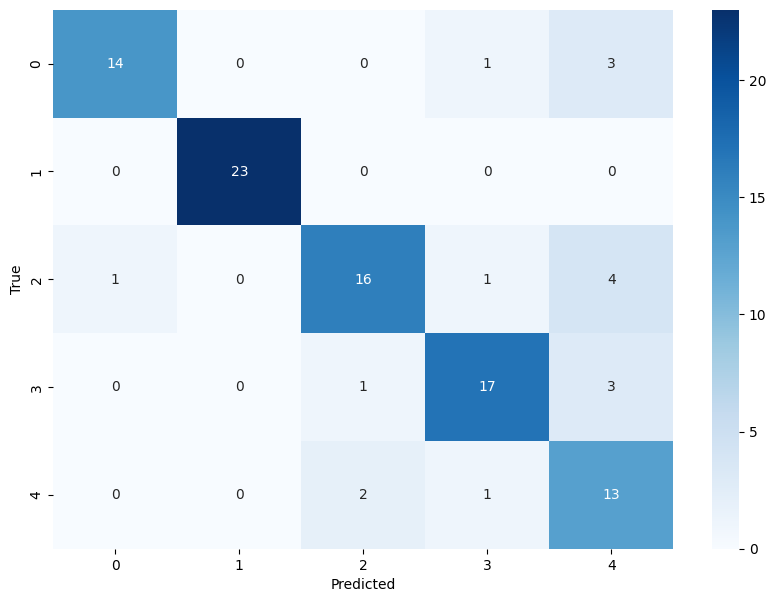

In [96]:
# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [97]:
# Classification Report
report = classification_report(y_val, y_pred_classes, target_names=['Left Swipe', 'Right Swipe', 'Stop', 'Thumbs Down', 'Thumbs Up'])
print(report)

              precision    recall  f1-score   support

  Left Swipe       0.93      0.78      0.85        18
 Right Swipe       1.00      1.00      1.00        23
        Stop       0.84      0.73      0.78        22
 Thumbs Down       0.85      0.81      0.83        21
   Thumbs Up       0.57      0.81      0.67        16

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.82       100
weighted avg       0.85      0.83      0.84       100



### 8. Video Frame Loader

In [98]:
FRAME_HEIGHT, FRAME_WIDTH = 64, 64
NUM_CLASSES = 5

# Function to load video frames
def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (FRAME_WIDTH, FRAME_HEIGHT))
        frames.append(frame)
    cap.release()
    return frames

### 9. Video Prediction

In [119]:
# Prediction on new input data (video)
def predict_new_data(video_path):
    frames = load_video_frames(video_path)
    predictive_input_array = np.asarray(frames).reshape(1, len(frames), FRAME_HEIGHT, FRAME_WIDTH, 3)
    prediction = model.predict(predictive_input_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    class_names = ['Left Swipe', 'Right Swipe', 'Stop', 'Thumbs Down', 'Thumbs Up']
    print('Prediction:', class_names[predicted_class])

    # Display the first frame of the video
    plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
    plt.title('First Frame of Input Video')
    plt.axis('off')
    plt.show()

### 10. Test Cases

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction: Stop


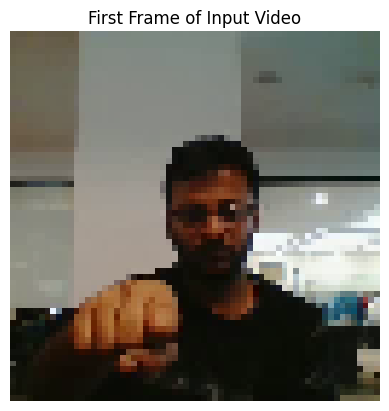

In [120]:
example_video = 'video/output_video.mp4'
predict_new_data(example_video) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction: Thumbs Up


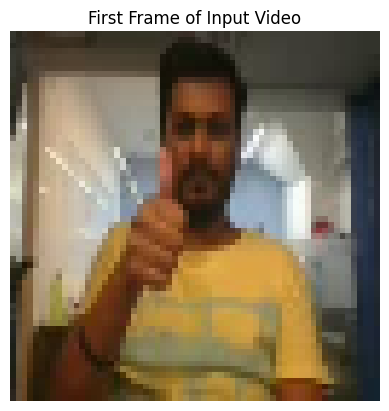

In [121]:
example_video = 'video/output_video1.mp4'
predict_new_data(example_video) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction: Right Swipe


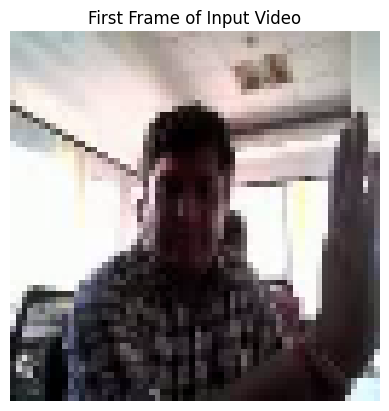

In [123]:
example_video = 'video/output_video2.mp4'
predict_new_data(example_video) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction: Stop


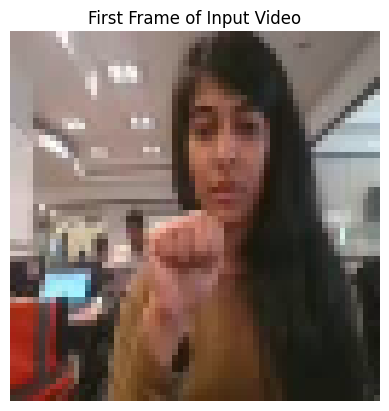

In [124]:
example_video = 'video/output_video3.mp4'
predict_new_data(example_video) 

### 11. Save the Model

In [131]:
# Example usage
model.save('3d_cnn_model.keras')

In [128]:
# Save the model weights
model.save_weights('3d_cnn_model_weights.weights.h5')

In [129]:
# Save model architecture to JSON
model_json = model.to_json()
with open('3d_cnn_model.json', 'w') as json_file:
    json_file.write(model_json)